# Binning raw Multidimensional Photoemission Spectroscopy (MPES) data and converting it into the NeXus format

This example shows how to generate xarray based h5 files from WSe2 trARPES measurement data as detailed in this [paper](https://www.nature.com/articles/s41597-020-00769-8) and how to generate a file in the standardised [MPES NeXus format](https://manual.nexusformat.org/classes/contributed_definitions/NXmpes.html#nxmpes) from it.
Due to the size of the example file (~6GB) you need at least 40 GB of memory on your computer you're executing this example on. If you just want to have a look on how to convert a pre-binned xarray based h5 file into the NeXus format you may have a look at the simpler [Convert to NeXus example](./E1%20Convert%20to%20NeXus.ipynb), which has lower hardware requirements.

## Download RAW data (trARPES data of WSe2)

Here, we just import `shutil` for extracting the downloaded zip archive and set the main file folder for holding the measurement data.

In [1]:
import os

os.environ["HS_ENDPOINT"] = "http://femto90.rz-berlin.mpg.de:5101"
os.environ["HS_USERNAME"] = "test_user1"
os.environ["HS_PASSWORD"] = "test"

In [2]:
#import shutil
#import os
FDIR = f'{os.getcwd()}/Scan049_1'
ECAL = f'{os.getcwd()}/energycal_2019_01_08'

#FDIR = f'/home/test_user1/Scan049_1'
#ECAL = f'/home/test_user1/energycal_2019_01_08'

Since the provided measurement files are rather large (~6GB), they are not directly provided with the example.
You can [download](https://zenodo.org/record/6369728/files/WSe2.zip) it from zenodo. This may take some time. Place the file in the directory of this notebook afterwards. Under Linux, macOS and in a NORTH container you can directly use the cell below to download the file with curl.

In [3]:
# ! curl -o WSe2.zip "https://zenodo.org/record/6369728/files/WSe2.zip"

Now we extract the measurement files.

In [4]:
# ! unzip 'WSe2.zip'

## Binning of measurement data

First we import the necessary packages. For a manual on how to install this dependencies refer to the provided [INSTALL.md](./INSTALL.md) file. If you're running a pre-built docker container or working with the NORTH tools, these dependencies are already available for you.

In [5]:
import time
start_time = time.time()

In [6]:
from mpes import base as base, fprocessing as fp, analysis as aly
import matplotlib.pyplot as plt
import numpy as np
import os
from dask import compute
import datetime as dt
import h5py

### Initial data binning for distortion correction

In [7]:
parp = fp.parallelHDF5Processor(folder=FDIR)
parp.gather(identifier=r'/*.h5', file_sorting=True)
len(parp.files)

100

In [8]:
# Bin a small range of of files to create a momentum map for distortion correction
parp.files = parp.files[0:50]
axes = ['X', 'Y', 't']
# Important to keep the whole detector area for the initial binning!
bins = [512, 512, 300]
ranges = [(0, 2048), (0, 2048), (64000, 68000)]
parp.parallelBinning(axes=axes, nbins=bins, ranges=ranges, scheduler='threads', ret=False)

100%|██████████| 7/7 [03:49<00:00, 32.84s/it]


### Determine correction landmarks

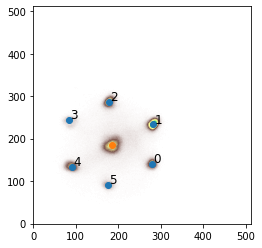

In [9]:
# Select an energy slice at the valence band maximum, containing the 6 K-points and the Gamma point as distinct features
mc = aly.MomentumCorrector(parp.combinedresult['binned'])
mc.selectSlice2D(slice(165, 175), 2)
# Extract these high-symmetry points 
mc.featureExtract(mc.slice, sigma=5, fwhm=10, sigma_radius=3)
mc.view(points=mc.features, annotated=True)

### Calculate thin plate spline symmetry correction

In [10]:
# Calculate a non-linear coordinate transformation based on thin plate splines that restores 6-fold symmetry
mc.splineWarpEstimate(image=mc.slice, landmarks=mc.pouter_ord, include_center=True,
                      iterative=False, interp_order=2, update=True)
mc.view(image=mc.slice_transformed, annotated=True, points={'feats':mc.ptargs}, backend='bokeh', crosshair=True, radii=[75,110,150], crosshair_thickness=0.2)

### Image registration

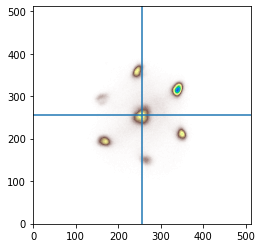

In [11]:
# Apply a coordinate translation to move the image into the center of the detector
mc.coordinateTransform(type='translation', xtrans=70., ytrans=70., keep=True)
plt.imshow(mc.slice_transformed, origin='lower', cmap='terrain_r')
plt.axvline(x=256)
plt.axhline(y=256)

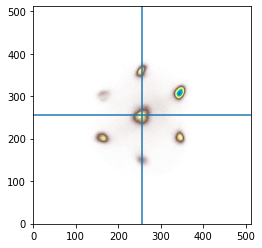

In [12]:
# Rotate the image into a high-symmetry direction
mc.coordinateTransform( type='rotation', angle=-5, center=(256., 256.), keep=True)
plt.imshow(mc.slice_transformed, origin='lower', cmap='terrain_r')
plt.axvline(x=256)
plt.axhline(y=256)

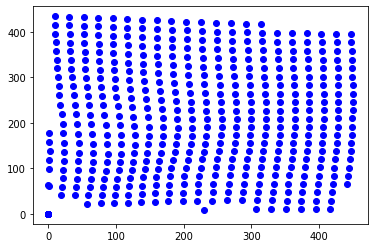

In [13]:
# Display the final deformation field
subs = 20
plt.scatter(mc.cdeform_field[::subs,::subs].ravel(), mc.rdeform_field[::subs,::subs].ravel(), c='b')

### Momentum calibration

In [14]:
# Pick one high-symmetry point
point_b = [252.,255.]
# Pick the BZ center
point_a = [308.,346.]
# give the distance of the two in inverse Angstrom
distance = np.pi*4/3/3.297
# Momentum calibration assuming equal scaling along both x and y directions (equiscale=True)
# Requirements : pixel coordinates of and the momentum space distance between two symmetry points, 
# plus the momentum coordinates
# of one of the two points 
ext = mc.calibrate(mc.slice_transformed,
                   point_from=point_a,
                   point_to=point_b,
                   dist=distance,
                   equiscale=True,
                   ret=['extent'])

Text(0, 0.5, '$k_y$')

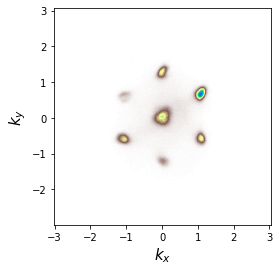

In [15]:
# Display corrected image in calibrated coordinates
mc.view(image=mc.slice_transformed, imkwds=ext)
plt.xlabel('$k_x$', fontsize=15)
plt.ylabel('$k_y$', fontsize=15)

### Energy calibration

In [16]:
# Bin traces for energy calibration
axes = ['t']
bins = [1000]
ranges = [(63000, 80000)]
traces, tof = fp.extractEDC(folder=ECAL,
                            axes=axes, bins=bins, ranges=ranges)

[########################################] | 100% Completed | 7.84 ss


In [17]:
# Applied bias voltages (negated, in order to achieve negative binding energies, E-E_F)
voltages = np.arange(-12.2, -23.2, -1)
ec = aly.EnergyCalibrator(biases=voltages, traces=traces, tof=tof)

In [18]:
# Normalize traces to maximum
ec.normalize(smooth=True, span=7, order=1)
ec.view(traces=ec.traces_normed, xaxis=ec.tof, backend='bokeh')

In [19]:
# Define a TOF feature range, and translate it for each of the traces according to their shift in bias voltage
rg = [(65000, 65200)]
ec.addFeatures(traces=ec.traces_normed, refid=0, ranges=rg[0], infer_others=True, mode='append')
ec.featranges

[(64997.5, 65201.5),
 (65269.5, 65490.5),
 (65558.5, 65779.5),
 (65847.5, 66085.5),
 (66170.5, 66408.5),
 (66493.5, 66748.5),
 (66850.5, 67122.5),
 (67207.5, 67496.5),
 (67598.5, 67887.5),
 (67989.5, 68312.5),
 (68414.5, 68771.5)]

In [20]:
# Extract the first peak from each feature range
ec.featureExtract(traces=ec.traces_normed, ranges=ec.featranges)
ec.view(traces=ec.traces_normed, peaks=ec.peaks, backend='bokeh')

### Calculate energy calibration

In [21]:
# calculate the energy calibration (3rd order polynom). Eref corresponds to the binding energy (E-E_F) of the selected feature in the refid trace.
refid=5
Eref=-1.3
axs = ec.calibrate(ret='all', Eref=Eref, t=ec.tof, refid=refid)
ec.view(traces=ec.traces_normed, xaxis=ec.calibration['axis'], backend='bokeh')

### Quality of calibration

(-15.0, 5.0)

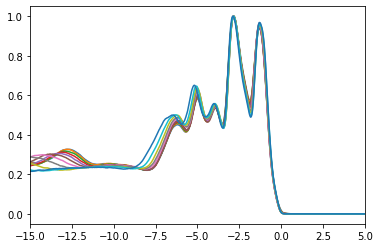

In [22]:
# inspect the quality of the energy calibration
for i in range(0,len(voltages)):
    plt.plot(ec.calibration['axis']-(voltages[i]-voltages[refid]), ec.traces_normed[i])
plt.xlim([-15,5])

### Inspect calibration function

(63400.0, 69800.0)

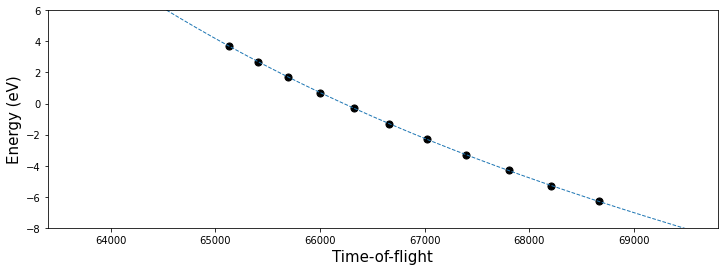

In [23]:
# energy calibration function vs. TOF
ec.view(traces=ec.calibration['axis'][None,:], xaxis=ec.tof, backend='matplotlib', show_legend=False)
plt.scatter(ec.peaks[:,0], ec.biases-ec.biases[refid]+Eref, s=50, c='k')
plt.xlabel('Time-of-flight', fontsize=15)
plt.ylabel('Energy (eV)', fontsize=15)
plt.ylim([-8,6])
plt.xlim([63400,69800])

### Dataframe processor

In [24]:
# create the dask data frame processor
dfp = fp.dataframeProcessor(datafolder=FDIR)
dfp.read(source='folder', ftype='h5', timeStamps=False)

### Apply energy calibration

In [25]:
# apply the energy calibration
dfp.appendEAxis(E0=ec.calibration['E0'], a=ec.calibration['coeffs'])
dfp.edf.head(8)

,X,Y,t,MasterRstCtr,ADC,State Input,E
0,0.0,0.0,0.0,0.0,0.0,0.0,6536.661596
1,365.0,1002.0,70101.0,0.0,6317.0,0.0,-9.267996
2,761.0,818.0,75615.0,0.0,6316.0,0.0,-22.034791
3,692.0,971.0,66455.0,0.0,6317.0,0.0,-0.690717
4,671.0,712.0,73026.0,0.0,6317.0,0.0,-15.172372
5,299.0,1164.0,68459.0,0.0,6316.0,0.0,-5.843804
6,571.0,665.0,73903.0,0.0,6316.0,0.0,-17.221760
7,822.0,545.0,72632.0,0.0,6318.0,0.0,-14.316472


### Apply distortion correction

In [26]:
# apply the distortion correction
dfp.applyKCorrection(type='tps_matrix',
                     rdeform_field = mc.rdeform_field,
                     cdeform_field = mc.cdeform_field,
                     X='X', Y='Y', newX='Xm', newY='Ym')
dfp.edf.head(8)

Calculating inverse Deformation Field, might take a moment...


,X,Y,t,MasterRstCtr,ADC,State Input,E,Xm,Ym
0,0.0,0.0,0.0,0.0,0.0,0.0,6536.661596,0.000000,0.000000
1,365.0,1002.0,70101.0,0.0,6317.0,0.0,-9.267996,589.545138,1295.424800
2,761.0,818.0,75615.0,0.0,6316.0,0.0,-22.034791,1041.978489,1090.684714
3,692.0,971.0,66455.0,0.0,6317.0,0.0,-0.690717,962.695159,1234.757606
4,671.0,712.0,73026.0,0.0,6317.0,0.0,-15.172372,944.935070,993.557661
5,299.0,1164.0,68459.0,0.0,6316.0,0.0,-5.843804,515.392132,1446.654647
6,571.0,665.0,73903.0,0.0,6316.0,0.0,-17.221760,835.858206,955.722206
7,822.0,545.0,72632.0,0.0,6318.0,0.0,-14.316472,1091.125399,838.265145


### Apply momentum calibration

In [27]:
# apply the momentum calibration
dfp.appendKAxis(point_b[0], point_b[1], X='Xm', Y='Ym', rstart=parp.binranges[0][0],
                cstart=parp.binranges[1][0],
                rstep=parp.binsteps[0],
                cstep=parp.binsteps[1],
                fc=mc.calibration['coeffs'][0],
                fr=mc.calibration['coeffs'][1])
dfp.edf.head(8)

,X,Y,t,MasterRstCtr,ADC,State Input,E,Xm,Ym,kx,ky
0,0.0,0.0,0.0,0.0,0.0,0.0,6536.661596,0.000000,0.000000,-2.996361,-3.032032
1,365.0,1002.0,70101.0,0.0,6317.0,0.0,-9.267996,589.545138,1295.424800,-1.243891,0.818722
2,761.0,818.0,75615.0,0.0,6316.0,0.0,-22.034791,1041.978489,1090.684714,0.101004,0.210116
3,692.0,971.0,66455.0,0.0,6317.0,0.0,-0.690717,962.695159,1234.757606,-0.134672,0.638384
4,671.0,712.0,73026.0,0.0,6317.0,0.0,-15.172372,944.935070,993.557661,-0.187466,-0.078602
5,299.0,1164.0,68459.0,0.0,6316.0,0.0,-5.843804,515.392132,1446.654647,-1.464317,1.268265
6,571.0,665.0,73903.0,0.0,6316.0,0.0,-17.221760,835.858206,955.722206,-0.511705,-0.191071
7,822.0,545.0,72632.0,0.0,6318.0,0.0,-14.316472,1091.125399,838.265145,0.247097,-0.540222


### Apply pump-probe delay axis conversion

In [28]:
# calculate the pump-probe delay from the ADC coordinates
ADCRange = (650, 6900)
timeRange = (-100, 200)
dfp.edf['delay'] = timeRange[0] + (dfp.edf['ADC']-ADCRange[0]) *\
    (timeRange[1] - timeRange[0])/(ADCRange[1]-ADCRange[0])
dfp.edf.head(8)

,X,Y,t,MasterRstCtr,ADC,State Input,E,Xm,Ym,kx,ky,delay
0,0.0,0.0,0.0,0.0,0.0,0.0,6536.661596,0.000000,0.000000,-2.996361,-3.032032,-131.199997
1,365.0,1002.0,70101.0,0.0,6317.0,0.0,-9.267996,589.545138,1295.424800,-1.243891,0.818722,172.015991
2,761.0,818.0,75615.0,0.0,6316.0,0.0,-22.034791,1041.978489,1090.684714,0.101004,0.210116,171.967987
3,692.0,971.0,66455.0,0.0,6317.0,0.0,-0.690717,962.695159,1234.757606,-0.134672,0.638384,172.015991
4,671.0,712.0,73026.0,0.0,6317.0,0.0,-15.172372,944.935070,993.557661,-0.187466,-0.078602,172.015991
5,299.0,1164.0,68459.0,0.0,6316.0,0.0,-5.843804,515.392132,1446.654647,-1.464317,1.268265,171.967987
6,571.0,665.0,73903.0,0.0,6316.0,0.0,-17.221760,835.858206,955.722206,-0.511705,-0.191071,171.967987
7,822.0,545.0,72632.0,0.0,6318.0,0.0,-14.316472,1091.125399,838.265145,0.247097,-0.540222,172.063995


### Bin 4D data in transformed grid

In [29]:
# process the 4-dimensional binning
axes = ['kx', 'ky', 'E', 'delay']
bins = [50, 50, 100, 21]
ranges = [(-2, 2), (-2, 2), (-3, 2), (-110, 190)]
# jittering of energy and ADC should best be done on the bin size of the hardware, 
# not the rebinned bin size. This requires reverse-calculating the jitter amplitudes
# from the bin sizes.
TOFrange=[64500,67000]
e_t_conversion = (base.tof2evpoly(ec.calibration['coeffs'],
                                  ec.calibration['E0'], 
                                  TOFrange[0])
                  - base.tof2evpoly(ec.calibration['coeffs'],
                                    ec.calibration['E0'], TOFrange[1])
                 ) / (TOFrange[1] - TOFrange[0])
d_adc_conversion = (timeRange[1] - timeRange[0]) / (ADCRange[1] - ADCRange[0])
jitter_amplitude = [0.5,
                    0.5,
                    1*bins[2]/abs(ranges[2][1]-ranges[2][0])*e_t_conversion,
                    1*bins[3]/abs(ranges[3][1]-ranges[3][0])*d_adc_conversion]
dfp.distributedBinning(axes=axes,
                       nbins=bins,
                       ranges=ranges,
                       scheduler='threads',
                       ret=False,
                       jittered=True,
                       jitter_amplitude=jitter_amplitude)

100%|██████████| 13/13 [20:20<00:00, 93.88s/it]


### Create metatada structure
This adds additional metadata to the h5 file. This data may also be provided through additional ELN entries through a NOMAD instance or with a handwriten file directly to the mpes parser.

In [30]:
metadata = {}

In [31]:
# Manual Meta data
#General
metadata['experiment_summary'] = 'WSe2 XUV NIR pump probe data.'
metadata['entry_title'] = 'Valence Band Dynamics - 800 nm linear s-polarized pump, 0.6 mJ/cm2 absorbed fluence'
metadata['experiment_title'] = 'Valence band dynamics of 2H-WSe2'

#User
# Fill general parameters of NXuser
metadata['user0'] = {}
metadata['user0']['name'] = 'Julian Maklar'
metadata['user0']['role'] = 'Principal Investigator'
metadata['user0']['affiliation'] = 'Fritz Haber Institute of the Max Planck Society'
metadata['user0']['address'] = 'Faradayweg 4-6, 14195 Berlin'
metadata['user0']['email'] = 'maklar@fhi-berlin.mpg.de'

#NXinstrument
metadata['instrument'] = {}
metadata['instrument']['analyzer']={}
metadata['instrument']['analyzer']['slow_axes'] = "delay" # the scanned axes
metadata['instrument']['analyzer']['spatial_resolution'] = 10.
metadata['instrument']['analyzer']['energy_resolution'] = 110.
metadata['instrument']['analyzer']['momentum_resolution'] = 0.08
metadata['instrument']['analyzer']['projection'] = "reciprocal"
metadata['instrument']['analyzer']['working_distance'] = 4.
metadata['instrument']['analyzer']['lens_mode'] = "6kV_kmodem4.0_30VTOF.sav"

#probe beam
metadata['instrument']['beam']={}
metadata['instrument']['beam']['probe']={}
metadata['instrument']['beam']['probe']['incident_energy'] = 21.7
metadata['instrument']['beam']['probe']['incident_energy_spread'] = 0.11
metadata['instrument']['beam']['probe']['pulse_duration'] = 20.
metadata['instrument']['beam']['probe']['frequency'] = 500.
metadata['instrument']['beam']['probe']['incident_polarization'] = [1, 1, 0, 0] # p pol Stokes vector
metadata['instrument']['beam']['probe']['extent'] = [80., 80.] 
#pump beam
metadata['instrument']['beam']['pump']={}
metadata['instrument']['beam']['pump']['incident_energy'] = 1.55
metadata['instrument']['beam']['pump']['incident_energy_spread'] = 0.08
metadata['instrument']['beam']['pump']['pulse_duration'] = 35.
metadata['instrument']['beam']['pump']['frequency'] = 500.
metadata['instrument']['beam']['pump']['incident_polarization'] = [1, -1, 0, 0] # s pol Stokes vector
metadata['instrument']['beam']['pump']['incident_wavelength'] = 800. 
metadata['instrument']['beam']['pump']['average_power'] = 300.
metadata['instrument']['beam']['pump']['pulse_energy'] = metadata['instrument']['beam']['pump']['average_power']/metadata['instrument']['beam']['pump']['frequency']#µJ
metadata['instrument']['beam']['pump']['extent'] = [230., 265.] 
metadata['instrument']['beam']['pump']['fluence'] = 0.15

#sample
metadata['sample']={}
metadata['sample']['preparation_date'] = '2019-01-13T10:00:00+00:00'
metadata['sample']['sample_history'] = 'Cleaved'
metadata['sample']['chemical_formula'] = 'WSe2'
metadata['sample']['description'] = 'Sample'
metadata['sample']['name'] = 'WSe2 Single Crystal'

### Add additional EPCIS metadata
The following snippet adds metadata, which is normally read from the EPICS archive at FHI. Since this is not available in a public example we fill in the values manually here.

In [32]:
metadata['file'] = {}
metadata['file']["KTOF:Lens:Extr:I"] = -0.12877
metadata['file']["KTOF:Lens:UDLD:V"] = 399.99905
metadata['file']["KTOF:Lens:Sample:V"] = 17.19976
metadata['file']["trARPES:Carving:TEMP_RBV"] = np.nan
metadata['file']["trARPES:XGS600:PressureAC:P_RD"] = np.nan
metadata['file']["KTOF:Apertures:m1.RBV"] = 3.729931
metadata['file']["KTOF:Apertures:m2.RBV"] = -5.200078
metadata['file']["KTOF:Apertures:m3.RBV"] = -11.00043
metadata['file']["trARPES:Carving:TRX.RBV"] = np.nan
metadata['file']["trARPES:Carving:TRY.RBV"] = np.nan
metadata['file']["trARPES:Carving:TRZ.RBV"] = np.nan
metadata['file']["trARPES:Carving:THT.RBV"] = np.nan
metadata['file']["trARPES:Carving:PHI.RBV"] = np.nan
metadata['file']["trARPES:Carving:OMG.RBV"] = np.nan

### Generate xarray

In [33]:
res_xarray = dfp.gather_metadata(metadata_dict=metadata.copy(), ec=ec, mc=mc)

Gathering metadata from different locations
Building the xarray data object...
Done!


In [34]:
stop_time = time.time()

In [35]:
'{:.0f}:{:.0f}'.format((stop_time - start_time) // 60, (stop_time - start_time) % 60)

'25:13'

## Create a NeXus file from a xarray
This conversion basically follows the same procedure as in the [convert to NeXus example](./E1%20Convert%20to%20Nexus.ipynb). Please refer to this notebook for details on the convert function. Here, we are using the objects keywords of `convert` to pass the generated xarray directly, instead of loading a h5 datafile.

In [36]:
#from nexusparser.tools.dataconverter.convert import convert

In [37]:
#convert(input_file=["config_file.WSe2.json"],
#        objects=res_xarray,
#        reader='mpes',
#        nxdl='NXmpes',
#        output='WSe2.mpes.nxs')

## View the data with H5Web
H5Web is a tool for visualizing any data in the h5 data format. Since the NeXus format builds opon h5 it can be used to view this data as well. We just import the package and call H5Web with the output filename from the convert command above. For an analysis on NeXus data files please refer to [analysis example](./E3%20pyARPES%20analysis.ipynb).

You can also view this data with the H5Viewer or other tools from your local filesystem.

In [38]:
#from jupyterlab_h5web import H5Web

In [39]:
#H5Web('WSe2.mpes.nxs')